In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
%cd /content/drive/My Drive/google_colab/music_cvae/music_cvae_notebook/

/content/drive/My Drive/google_colab/music_cvae/music_cvae_notebook


In [32]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import random as rand
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import FloatStorage, nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from chord_v2 import chord
from blstm_dataset import my_blstm_dataset

In [33]:
BATCH_SIZE = 32
EPOCHS = 30

RANDOM_SEED = 1

cuda = not False and torch.cuda.is_available()

torch.manual_seed(RANDOM_SEED)

In [34]:
td = my_blstm_dataset()
train_loader = torch.utils.data.DataLoader(
    td, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    td, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda" if cuda else "cpu")

In [35]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.latent_dim = 15
        self.seq_dim = 16
        self.feature_dim = 12 + 2
        self.input_dim = self.seq_dim*self.feature_dim
        self.fc_lstm1 = nn.LSTM(self.feature_dim ,self.seq_dim,batch_first = True,bidirectional = True)
        self.fc1 = nn.Linear((16*32 + 1), 100)
        self.fc21 = nn.Linear(100, self.latent_dim)
        self.fc3 = nn.Linear(self.latent_dim + 1, 100)
        self.fc4 = nn.Linear(100, self.input_dim)
        self.fc_lstm2 = nn.LSTM(self.feature_dim ,self.seq_dim ,batch_first = True)
        self.fc5 = nn.Linear(16*16, self.input_dim)

    def encode(self, x, labels):
        # print(x.view(-1, self.input_dim))
        f1_lstm_out, f1_lstm_h = self.fc_lstm1(x)
        #f1_lstm_out = F.relu(f1_lstm_out)
        #print(f1_lstm_out.shape)
        h1 = F.relu(
            self.fc1(torch.cat((f1_lstm_out.reshape(-1, 16*32), labels.view(-1, 1)), dim=-1)))
        return self.fc21(h1)

    def decode(self, latent, consonanse, chord_d, chord_type):
        h3 = F.relu(
            self.fc3(torch.cat((latent, consonanse.view(-1, 1)), dim=-1)))
        h4 = self.fc4(h3)
        h4 = torch.t(h4).reshape(-1, self.seq_dim, self.feature_dim)
        h5, h5_c = self.fc_lstm2(h4)
        h5 = h5.reshape(-1,16*16)
        h5 = self.fc5(h5)
        h5 = F.relu(h5)
        recon_x = h5.reshape(-1, self.seq_dim, self.feature_dim)
        #print(h5.shape)
        h_consonanse = self.calc_chord(recon_x, chord_d, chord_type)
        return torch.softmax(recon_x,dim = 2), torch.sigmoid(h_consonanse)

    def forward(self, x, chord_d, chord_type, consonance, out_fl = False):
        x = x.float()
        if not out_fl:
            consonance_conditional = self.calc_chord(
                x, chord_d, chord_type)
        else:
            consonance_conditional = consonance_num
        latent = self.encode(x, consonance_conditional)
        return self.decode(latent, consonance_conditional, chord_d, chord_type)

    def calc_chord(self, x, chord_d, chord_type):
        cd = chord()
        ret_tensor = torch.zeros(len(x))

        for i, (melody_i, chord_i, chord_type_i) in enumerate(zip(x, chord_d, chord_type)):
            ret_tensor[i] = cd.calc_consonance_conditional(
                melody_i, chord_i, chord_type_i)

        return ret_tensor

In [36]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [37]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, chord_d, chord_type, consonance):
    cd = chord()
    BCE = F.binary_cross_entropy(
        recon_x.float().view(-1, 16*(12 + 2)), x.float().view(-1, 16*(12 + 2)), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #recon_x = torch.t(recon_x).reshape(-1, 16, (12 + 2))
    # print(torch.t(x).reshape(-1, 13))

    """ConsonanseLoss = F.binary_cross_entropy(cd.loss_exam(recon_x, labels),
                                            cd.loss_exam(x[0], labels).float().detach())"""
                              
    """
    ConsonanseLoss = torch.zeros(1, requires_grad=True)

    for i, (melody_i, chord_i, chord_type_i, consonance_i) in enumerate(zip(x, chord_d, chord_type, consonance)):
        ConsonanseLoss = ConsonanseLoss + (
            consonance_i - cd.calc_consonance_loss(melody_i, chord_i, chord_type_i).detach())**2

    # ConsonanseLoss = ConsonanseLoss.sum()
    ConsonanseLoss = BCE.item()/10*ConsonanseLoss
    """
    return BCE


In [38]:
def train(epoch):
    model.train()
    train_loss = 0
    train_consonanse_loss = 0
    cnt = 1
    for batch_idx, (melody, chord_d, chord_type) in enumerate(train_loader):
        # print(data.size(), labels.size())
        # print(labels)
        melody = melody.to(device)
        chord_d = chord_d.to(device)
        chord_type = chord_type.to(device)
        optimizer.zero_grad()
        recon_batch, consonance = model(melody, chord_d, chord_type)
        loss = loss_function(
            recon_batch, melody, chord_d, chord_type, consonance)
        loss.backward()
        train_loss += loss.item()
        #train_consonanse_loss += consonanse_loss.item()
        optimizer.step()

        if cnt % (100) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(melody), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(melody)))
        cnt += 1

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss, train_consonanse_loss

In [39]:
def out_test():
    model.eval()
    test_loss = 0
    label_flag = True
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(train_loader):
            # print(data.size(), labels.size())
            # print(labels)
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            recon_batch, consonanse = model(data, labels)
            recon_batch = torch.t(recon_batch).reshape(-1, (12 + 1) * 2)
            recon_batch = recon_batch.to('cpu').detach().numpy().copy()
            output = pd.DataFrame(
                recon_batch,
                columns=['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b', 'rest',
                         'c_h', 'c#_h', 'd_h', 'd#_h', 'e_h', 'f_h', 'f#_h', 'g_h', 'g#_h',
                         'a_h', 'a#_h', 'b_h', 'rest_h'])
            print(output)
            output.to_csv('test_out.csv')
            break

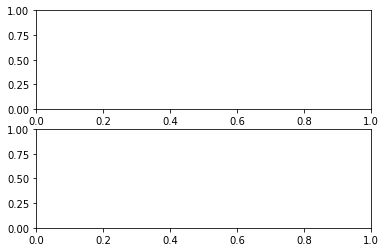

In [40]:
if __name__ == "__main__":
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    train_flag = False
    model_path = 'models/lstm_cvae_16.pth'

    loss_array = np.ndarray(0)
    consonanse_array = np.ndarray(0)
    epoch_array = np.arange(1, EPOCHS+1)
    if train_flag:
        for epoch in range(1, EPOCHS + 1):
            train_loss, train_consonanse_loss = train(epoch)
            # loss_array = np.append(loss_array, train_loss)
            # consonanse_array = np.append(consonanse_array, train_consonanse_loss)
            # test(epoch)
        torch.save(model.to('cpu').state_dict(), model_path)
    else:
        model.load_state_dict(torch.load(model_path))

    """
    out_test()
    ax1.plot(epoch_array, loss_array, color="blue", label="loss")
    ax2.plot(epoch_array, consonanse_array,
             color="green", label="consonanse_loss")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    fig.tight_layout()
    plt.show()
    """